# Curve LP Metrics Data Exploration

TODO:
1. Ensure that we are getting correct data from each subgraph

    Known issues:

    a. Potentially wrong swap and LP event data from Messari.
    
    b. Convex community subgraph does not have enough data on pool reserve balances.

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from datafetcher import DataFetcher
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [103]:
pool_name = '3pool'
datafetcher = DataFetcher('2023-04-25', '2023-04-26', step_size=50)
df_pool = datafetcher.get_pool_data(pool_name)

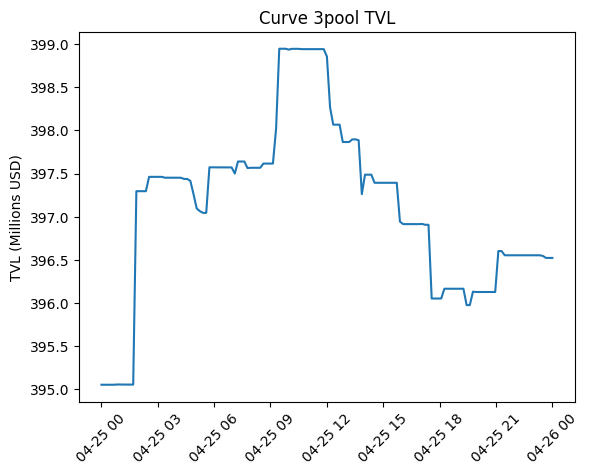

In [104]:
fig, ax = plt.subplots()

ax.plot(df_pool.index, df_pool['totalValueLockedUSD']/1e6, label='totalValueLockedUSD')
ax.set_ylabel('TVL (Millions USD)')
ax.set_title(f"Curve {pool_name} TVL")
ax.tick_params(axis='x', rotation=45)

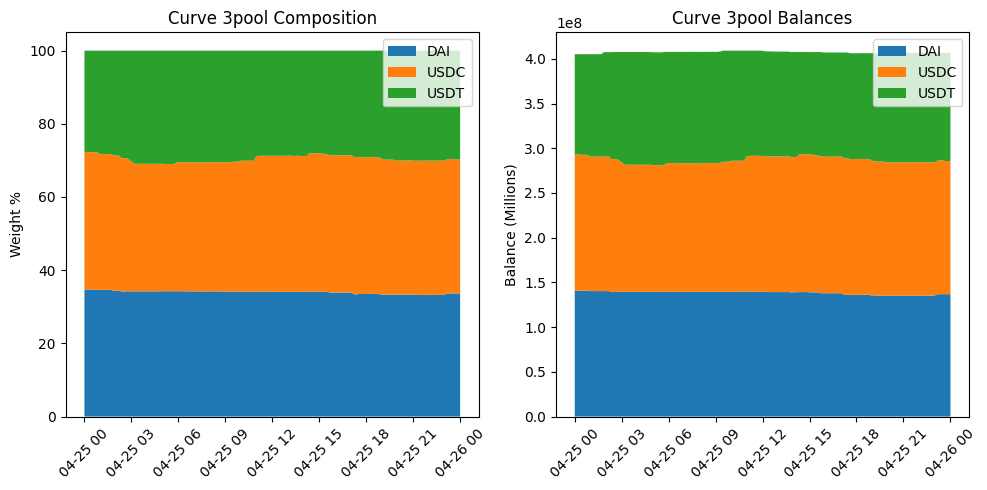

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].stackplot(df_pool.index, df_pool['DAI.weight'], df_pool['USDC.weight'], df_pool['USDT.weight'], labels=['DAI', 'USDC', 'USDT'])
axs[0].set_ylabel('Weight %')
axs[0].set_title(f"Curve {pool_name} Composition")
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()

axs[1].stackplot(df_pool.index, df_pool['DAI.balance'], df_pool['USDC.balance'], df_pool['USDT.balance'], labels=['DAI', 'USDC', 'USDT'])
axs[1].set_ylabel('Balance (Millions)')
axs[1].set_title(f"Curve {pool_name} Balances")
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

fig.tight_layout()

In [106]:
df_swaps = datafetcher.get_swaps_data('3pool')

# Swap Metrics

In [107]:
in_USDC = df_swaps[df_swaps['tokenIn.symbol']=='USDC']['amountIn'].resample('1min').sum()
out_USDC = -1*df_swaps[df_swaps['tokenOut.symbol']=='USDC']['amountOut'].resample('1min').sum()
flow_USDC = pd.concat([in_USDC, out_USDC], axis=1).fillna(0)
flow_USDC['netFlow'] = flow_USDC['amountIn'] + flow_USDC['amountOut']

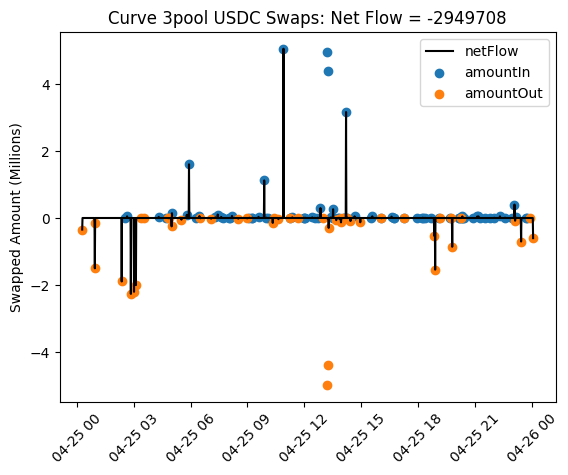

In [108]:
fig, ax = plt.subplots()

maskIn = flow_USDC[flow_USDC['amountIn'] != 0]
maskOut = flow_USDC[flow_USDC['amountOut'] != 0]

ax.plot(flow_USDC.index, flow_USDC['netFlow']/1e6, label='netFlow', color='black')
ax.scatter(maskIn.index, maskIn['amountIn']/1e6, label='amountIn')
ax.scatter(maskOut.index, maskOut['amountOut']/1e6, label='amountOut')

ax.set_ylabel('Swapped Amount (Millions)')
ax.set_title(f"Curve {pool_name} USDC Swaps: Net Flow = {round(flow_USDC['netFlow'].sum())}")
ax.tick_params(axis='x', rotation=45)

ax.legend()

# Pool Composition Metrics

In [109]:
def shannon(x):
    """
    Imagine a pool is a basket and each unit of each asset is a ball with that asset's color.
    Shannon entropy [loosely] measures how easy it is to predict the color of a ball picked at random.
    """
    proportions = x / np.sum(x)
    entropy = -np.sum(proportions * np.log2(proportions))
    # print(f"The entropy of the pool is {entropy:.2f}")
    return entropy

def gini(x):
    """
    Gini coefficient measures the inequality in the pool.
    """
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    coef = total / (len(x)**2 * np.mean(x))
    # print(f"The Gini coefficient of the pool is {coef=:.2f}")
    return coef

In [110]:
df_pool['gini'] = df_pool[['DAI.weight', 'USDC.weight', 'USDT.weight']].apply(gini, axis=1)
df_pool['shannon'] = df_pool[['DAI.weight', 'USDC.weight', 'USDT.weight']].apply(shannon, axis=1)

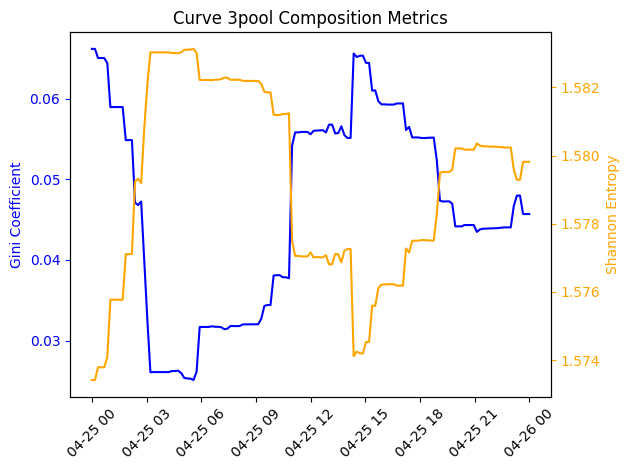

In [111]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_pool.index, df_pool['gini'], label='gini', c='blue')
ax2.plot(df_pool.index, df_pool['shannon'], label='shannon', c='orange')

ax1.set_ylabel('Gini Coefficient', c='blue')
ax2.set_ylabel('Shannon Entropy', c='orange')

ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='orange')

ax1.set_title(f"Curve {pool_name} Composition Metrics")

fig.tight_layout()